# OPDI Hexaero 
Implementation of HexAero ID based on runway hexagonification.

In [1]:
# Spark imports
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import udf, pandas_udf, col, PandasUDFType, lit, round, array_contains
from pyspark.sql.functions import monotonically_increasing_id, row_number, col
from pyspark.sql.types import DoubleType, StructType, StructField
from pyspark.sql.functions import when, split, col, concat_ws
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Regular imports
from IPython.display import display, HTML
import os, time
import subprocess
import os,shutil
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import h3pandas
import h3

# Settings
project = "project_aiu"

# Getting today's date
today = datetime.today().strftime('%d %B %Y')

# Setting logging properties
shutil.copy("/runtime-addons/cmladdon-2.0.40-b154/log4j.properties", "/etc/spark/conf/") 

# Spark Session Initialization
spark = SparkSession.builder \
    .appName("OSN ADEP ADES Identification") \
    .config("spark.log.level", "ERROR")\
    .config("spark.hadoop.fs.azure.ext.cab.required.group", "eur-app-aiu") \
    .config("spark.kerberos.access.hadoopFileSystems", "abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/aiu.db/unmanaged") \
    .config("spark.driver.cores", "1") \
    .config("spark.driver.memory", "8G") \
    .config("spark.executor.memory", "8G") \
    .config("spark.executor.cores", "1") \
    .config("spark.executor.instances", "2") \
    .config("spark.dynamicAllocation.maxExecutors", "20") \
    .config("spark.network.timeout", "800s") \
    .config("spark.executor.heartbeatInterval", "400s") \
    .config("spark.driver.maxResultSize", "4g") \
    .enableHiveSupport() \
    .getOrCreate()

# Get environment variables
engine_id = os.getenv('CDSW_ENGINE_ID')
domain = os.getenv('CDSW_DOMAIN')

# Format the URL
url = f"https://spark-{engine_id}.{domain}"

# Display the clickable URL
display(HTML(f'<a href="{url}">{url}</a>'))

Setting spark.hadoop.yarn.resourcemanager.principal to quinten.goens


## Transfer & filter OPDI runway hexagons

In [2]:
#query = """
#INSERT INTO project_aiu.opdi_runway_hexagons_bucketed_europe 
#SELECT
#    AIRPORT_IDENT,
#    LE_IDENT,
#    LE_HEADING_DEG,
#    HE_IDENT,
#    HE_HEADING_DEG,
#    HEX_ID,
#    HEX_RES,
#    HEX_LON,
#    HEX_LAT,
#    GATE_ID,
#    GATE_ID_NR
#FROM
#    project_aiu.opdi_runway_hexagons
#WHERE
#    HEX_LAT BETWEEN 26.74617 AND 70.25976
#    AND HEX_LON BETWEEN -25.86653 AND 49.65699;"""
#
#filtered_df = spark.sql(query)

## Create osn h3 osn statevector sample 7 days
Query irst 7 days of 2023, bucketed on icao24, callsign, event_time and h3_res_11.

In [3]:
#query = """
#INSERT INTO project_aiu.osn_h3_statevectors_bucket_sample 
#SELECT
#    *
#FROM
#    project_aiu.osn_h3_statevectors
#WHERE
#    EVENT_TIME BETWEEN 1672531201 AND 1673135999""" 
#
#filtered_df = spark.sql(query)

## Query testing sample function

In [4]:
def get_data_within_timeframe(spark, table_name, start_date, stop_date):
    """
    Retrieves records from a specified Spark table within the given timeframe.

    Args:
    spark (SparkSession): The SparkSession object.
    table_name (str): The name of the Spark table to query.
    start_date (str): The start date in 'YYYY-MM-DD' format.
    stop_date (str): The stop date in 'YYYY-MM-DD' format.

    Returns:
    pyspark.sql.dataframe.DataFrame: A DataFrame containing the records within the specified timeframe.
    """
    # Convert dates to POSIX time (seconds since epoch)
    start_posix = int(time.mktime(time.strptime(start_date, '%Y-%m-%d')))
    stop_posix = int(time.mktime(time.strptime(stop_date, '%Y-%m-%d')))

    # Load the table
    df = spark.table(table_name)

    # Filter records based on event_time column
    filtered_df = df.filter((col('event_time') > start_posix) & (col('event_time') <= stop_posix))

    return filtered_df

#sdf.write.format('parquet').save("abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/aiu.db/unmanaged/day_osn_h3_statevectors1.parquet")

#sdf = spark.read.format('parquet').load("abfs://storage-fs@cdpdllive.dfs.core.windows.net/data/project/aiu.db/unmanaged/day_osn_h3_statevectors1.parquet")

## Create airport runway hexagonification spark dataset 

#### To do:
   * Upload airport_concentric_c_hex_res_6.arrow dataset to datalake.

In [5]:
df_apt = pd.read_parquet('../data/airport_hex/airport_concentric_c_hex_res_6.arrow')

# Filter out relevant hexagons
df_apt = df_apt[df_apt.max_c_radius_nm<=15]
df_apt = df_apt[['ident','hex_id']].explode('hex_id')
df_apt = df_apt[~df_apt.hex_id.isna()]

# Getting h3 positions of hexagons 
df_apt['geo'] = df_apt['hex_id'].apply(lambda l:h3.h3_to_geo(l))
df_apt['lat'] = df_apt['geo'].apply(lambda l:l[0])
df_apt['lon'] = df_apt['geo'].apply(lambda l:l[1])
df_apt = df_apt.drop('geo',axis=1)

# OSN bounding box filter
f_lat = np.logical_and(df_apt.lat >=26.74617, df_apt.lat <= 70.25976)  
f_lon = np.logical_and(df_apt.lon >=-25.86653, df_apt.lon <= 49.65699)  
f = np.logical_and(f_lat, f_lon)
df_apt = df_apt[f]

# Renaming columns 
df_apt.columns = ['apt_' + x for x in df_apt.columns]

# Grouping by hex id
df_apt = df_apt.groupby('apt_hex_id').agg(list)['apt_ident'].reset_index()

# Creating spark df
sdf_apt = spark.createDataFrame(df_apt)

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:371: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.


## Applying hexagonification algorithm

### ~Helper function: Adding an ID to each statevector~

In [6]:
def add_sv_id(df: DataFrame) -> DataFrame:
    """
    Create a numeric ID for each statevector (sv) in a Spark DataFrame. The IDs start from 1 and are consecutive.
    
    Parameters:
    df (DataFrame): The Spark DataFrame to which the statevector IDs will be added.
    
    Returns:
    DataFrame: A Spark DataFrame with an additional column 'sv_id' that contains the unique, consecutive IDs starting from 1.
    """
    # Define a window specification without partitioning (over all rows)
    window_spec = Window.orderBy(monotonically_increasing_id())
    
    # Add a new column 'statevector_id' which is the row number over the specified window
    df = df.withColumn('sv_id_tmp', row_number().over(window_spec))
    
    # Offset 'statevector_id' to start from 1
    df = df.withColumn('sv_id', df['sv_id_tmp'])
    
    # Drop the temporary column
    df = df.drop('sv_id_tmp')
    
    return df


### Clean statevector data & filter out low altitude (<FL50)

In [7]:
# Query data from datalake sample 
sv = get_data_within_timeframe( # State Vectors sv
    spark = spark, 
    table_name = 'project_aiu.osn_h3_statevectors_bucket_sample', 
    start_date = '2023-01-01', 
    stop_date = '2023-01-08')

# Filter out rows with missing crucial data
sv_f = sv.dropna(subset=['lat', 'lon', 'baro_altitude'])

# Add statevector id (commented out because expensive)
#sv_f = add_sv_id(sv_f)

# Rename callsign to flight_id (official term)
sv_f = sv_f.withColumnRenamed("callsign", "flight_id")

# Replace missing 'flight_id' with empty string
sv_f = sv_f.fillna({'flight_id': ''})

# Add temporary track id (helps later on)
sv_f = sv_f.withColumn('track_id', F.concat_ws('_', F.col('icao24'), F.col('flight_id')))

# Convert event_time from posixtime to datetime 
sv_f = sv_f.withColumn('event_time', F.to_timestamp(F.col('event_time')))

# Add flight level extracted from baro_altitude
sv_f = sv_f.withColumn('flight_level', (col('baro_altitude') * 3.28084 / 100).cast('int'))

# Select columns of interest
columns_of_interest = [
    'track_id', 'icao24', 'flight_id', 'event_time', 'lat', 'lon',  'flight_level',
    'heading', 'vert_rate',  'on_ground', 'h3_res_6', 'h3_res_11'
]
sv_f = sv_f.select(columns_of_interest)

# Filter out low altitude statevectors 
sv_low_alt = sv_f.filter(col('flight_level') <= 50).cache()

# Sampling for testing
sv_low_alt = sv_low_alt.limit(1000000)

Hive Session ID = b309aa33-f85c-45c2-a0b9-ca3ec46a7a53


### First narrowing down: Airport merge

In [8]:
# Merge airports hexaero grid (sdf_apt) onto statevectors to see which tracks are within 15 NM (+-h3 res 6 inaccuracy). 
sv_nearby_apt = sv_low_alt.join(sdf_apt, (sv_low_alt.h3_res_6 == sdf_apt.apt_hex_id), "left")

### Second narrowing down: Runway merge

In [9]:
## Load runway spark dataframe (rwy_sdf) 
rwy_sdf = spark.table('project_aiu.opdi_runway_hexagons_bucketed_europe')
rwy_cols_of_interest = [
    'airport_ident', 
    'le_ident', 
    'le_heading_deg', 
    'he_ident', 
    'he_heading_deg',
    'hex_id', 
    'gate_id', 
    'gate_id_nr'] 
rwy_sdf = rwy_sdf.select(rwy_cols_of_interest)

# Using the apt_ident provided by the first 'airport merge' speeds up the merge dramatically
sv_on_rwy = sv_nearby_apt.join(
    rwy_sdf, 
    (sv_nearby_apt.h3_res_11 == rwy_sdf.hex_id) & 
    array_contains(sv_nearby_apt.apt_ident, rwy_sdf.airport_ident), 
    "inner")

### Assign new track_id
Currently the track_id is the icao24 and flight_id concatenated. However, multiple flights with the same icao24 and flight_id can happen. Here we split up tracks when there's subsequent statevectors separated by at least 40 minutes.

In [10]:
# Define a window spec partitioned by 'id' and ordered by 'time'
windowSpec = Window.partitionBy("track_id").orderBy("event_time")

# Calculate the time difference between consecutive rows
sv_on_rwy = sv_on_rwy.withColumn("time_diff", F.col("event_time").cast("long") - F.lag("event_time", 1).over(windowSpec).cast("long"))

# Flag rows where the time difference exceeds 40 minutes (40*60 seconds)
sv_on_rwy = sv_on_rwy.withColumn("new_flight_flag", F.when(F.col("time_diff") > 60*40, 1).otherwise(0))

# Cumulative sum of flags to create a sub-id
sv_on_rwy = sv_on_rwy.withColumn("sub_id", F.sum("new_flight_flag").over(windowSpec.rowsBetween(Window.unboundedPreceding, 0)))

# Concatenate original 'id' with 'sub_id' to form a new unique 'id'
sv_on_rwy = sv_on_rwy.withColumn(
    "track_id", 
    F.concat_ws("_", F.trim(F.col("track_id")), F.col("sub_id").cast("string"))
)

# Drop redundant columns to clean up
sv_on_rwy = sv_on_rwy.drop(*['time_diff', 'new_flight_flag', 'sub_id'])

### Split gate_id into multiple variables

* `gate_type`: Indicates the type of gate (runway_hexagons - rwy, low_numbered_approach_hexagons - le, high_numbered_approach_hexagons - he). 
* `gate_distance_from_rwy_nm`: Indicates the distance from the runway le/he center. 

In [11]:
sv_on_rwy = sv_on_rwy.withColumn(
    "gate_type", 
    when(
        col("gate_id") == "runway_hexagons", "runway_hexagons"
    ).otherwise(
        concat_ws(
            "_", 
            split(col("gate_id"), "_").getItem(0),
            split(col("gate_id"), "_").getItem(1),
            split(col("gate_id"), "_").getItem(2),
            split(col("gate_id"), "_").getItem(3)
        )
    )
).withColumn(
    "gate_distance_from_rwy_nm",
    when(
        col("gate_id") == "runway_hexagons", 0
    ).otherwise(
        split(col("gate_id"), "_").getItem(4).cast("int")
    )
)


# Rename the values in the 'gate_type' column
sv_on_rwy = sv_on_rwy.withColumn(
    "gate_type",
    when(sv_on_rwy["gate_type"] == "high_numbered_approach_hexagons", "hex_he")
    .when(sv_on_rwy["gate_type"] == "runway_hexagons", "hex_rwy")
    .when(sv_on_rwy["gate_type"] == "low_numbered_approach_hexagons", "hex_le")
    .otherwise(sv_on_rwy["gate_type"])
)

### Collect heuristics for later analysis

To determine whether an aircraft lands or takes-off on a certain runway successfully we need well defined heuristics. For HexAero the following heuristics are determined for later analysis:
* `min_gate_distance`: The minimum distance a track_id reaches to a certain le/he runway.
* `max_gate_distance`: The maximum distance a track_id reaches to a certain le/he runway.
time_entry_min_gate_distance
flight_lvl_min_gate_distance
heading_min_gate_distance
time_entry_max_gate_distance
flight_lvl_max_gate_distance
heading_max_gate_distance

In [12]:
# Filter down to necessary elements
cols_of_interest = [
    'track_id', 
    'icao24', 
    'flight_id', 
    'event_time', 
    'flight_level', 
    'heading',
    'airport_ident',
    'le_ident',
    'le_heading_deg', 
    'he_ident', 
    'he_heading_deg', 
    'gate_id',
    'gate_id_nr', 
    'gate_type', 
    'gate_distance_from_rwy_nm'] 

sv_on_rwy = sv_on_rwy.select(cols_of_interest)

# Create a copy of the DataFrame
sv_on_rwy_cp = sv_on_rwy.cache()  # Using cache to optimize as the data is used multiple times

# Group the data and compute the minimum and maximum 'gate_distance_from_rwy_nm' for each group
# Define the window specification based on the grouping
partition_cols = [
    "track_id", "icao24", "flight_id", "airport_ident", 
    "le_ident", "le_heading_deg", "he_ident", "he_heading_deg", "gate_type"]

windowSpec = Window.partitionBy(partition_cols)

# Get the intersections per landing/take-off 
# Create a DataFrame with unique gate_id counts per group
unique_counts = (
    sv_on_rwy_cp.groupBy(partition_cols + ["gate_id"])  # Include gate_id to get distinct rows
    .agg(F.count("gate_id").alias("count"))  # Counting gate_id occurrences
    .groupBy(partition_cols)  # Regroup to collapse gate_id
    .agg(F.count("gate_id").alias("intersected_subsections"))  # Count distinct gate_id
)

# Join this back to the original DataFrame to distribute the unique counts to all rows
sv_on_rwy_cp = sv_on_rwy_cp.join(
    unique_counts,
    on=partition_cols,
    how="left"
)

# Calculate the minimum and maximum gate distances from the runway for each group
sv_on_rwy_cp = sv_on_rwy_cp.withColumn(
    "min_gate_distance",
    F.min("gate_distance_from_rwy_nm").over(windowSpec)
).withColumn(
    "max_gate_distance",
    F.max("gate_distance_from_rwy_nm").over(windowSpec)
)

# Filter to ensure only rows with the minimum or maximum gate distances are retained
min_dist = sv_on_rwy_cp.filter(
    (F.col("gate_distance_from_rwy_nm") == F.col("min_gate_distance"))
)

max_dist = sv_on_rwy_cp.filter(
    (F.col("gate_distance_from_rwy_nm") == F.col("max_gate_distance"))
)

# Define the columns to group by
cols_to_group = [
    "track_id", "icao24", "flight_id", "airport_ident", "le_ident", 
    "le_heading_deg", "he_ident", "he_heading_deg", "gate_type",
    "min_gate_distance", "max_gate_distance", "intersected_subsections"
]

# Group by and aggregate min_dist
min_dist_agg = min_dist.groupBy(cols_to_group).agg(
    F.min("event_time").alias("time_entry_min_gate_distance"),
    F.expr("percentile_approx(flight_level, 0.5)").alias("flight_lvl_min_gate_distance"),
    F.expr("percentile_approx(heading, 0.5)").alias("heading_min_gate_distance")
)

# Group by and aggregate max_dist
max_dist_agg = max_dist.groupBy(cols_to_group).agg(
    F.min("event_time").alias("time_entry_max_gate_distance"),
    F.expr("percentile_approx(flight_level, 0.5)").alias("flight_lvl_max_gate_distance"),
    F.expr("percentile_approx(heading, 0.5)").alias("heading_max_gate_distance")
)

# Merge min_dist_agg and max_dist_agg on cols_to_group using an outer join
heuristics_df = min_dist_agg.join(
    max_dist_agg,
    on=cols_to_group, 
    how='outer'
)

# Define the specific gate types
gate_types = ["hex_le", "hex_he", "hex_rwy"]  # Replace with actual gate type values

# Final pivot to organize by 'gate_type'
heuristics_df = heuristics_df.groupBy(
    "track_id", "icao24", "flight_id", "airport_ident",
    "le_ident", "le_heading_deg", "he_ident", "he_heading_deg"
).pivot("gate_type", gate_types).agg(
    F.first("time_entry_min_gate_distance").alias("time_entry_min"),
    F.first("flight_lvl_min_gate_distance").alias("flight_level_min"),
    F.first("heading_min_gate_distance").alias("heading_min"),
    F.first("time_entry_max_gate_distance").alias("time_entry_max"),
    F.first("flight_lvl_max_gate_distance").alias("flight_level_max"),
    F.first("heading_max_gate_distance").alias("heading_max"),
    F.first("min_gate_distance").alias("min_gate_distance"),
    F.first("max_gate_distance").alias("max_gate_distance"),
    F.first("intersected_subsections").alias("intersected_subsections")
)

heuristics_pdf = heuristics_df.toPandas()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, 

In [21]:
heuristics_pdf

track_id  icao24 flight_id airport_ident le_ident  \
0      0200ed_RAM776Z_0  0200ed  RAM776Z           GMMN      17R   
1      39cea8_TVF62DR_0  39cea8  TVF62DR           LFPO       02   
2      3b77f1_CTM1309_0  3b77f1  CTM1309           LFBD       11   
3       3c49c8_EWG71L_0  3c49c8  EWG71L            EDDL      05R   
4       3c49c9_GWI37A_0  3c49c9  GWI37A            EDDB      07R   
...                 ...     ...       ...           ...      ...   
19917         471fac__0  471fac                    LROP      08L   
19918  48c2a0_RYR2726_0  48c2a0  RYR2726           EPKK       07   
19919   4ba9ab_THY4MH_0  4ba9ab  THY4MH            LTFM      17L   
19920   4ca8d9_RYR5XF_0  4ca8d9  RYR5XF            EKCH      04R   
19921         a254f7__0  a254f7                    EGLL      09R   

       le_heading_deg he_ident  he_heading_deg hex_le_time_entry_min  \
0               164.0      35L           344.0                   NaT   
1                18.0       20           198.0                   NaT   
2               107.0       29           287.0                   NaT   
3                53.0      23L           233.0   2023-01-07 17:33:40   
4                69.0      25L           249.0                   NaT   
...               ...      ...             ...                   ...   
19917            84.0      26R           264.0                   NaT   
19918            78.0       25           258.0                   NaT   
19919           174.0      35R           354.0   2023-01-04 11:59:30   
19920            41.0      22L           221.0                   NaT   
19921            90.0      27L           270.0                   NaT   

       hex_le_flight_level_min  ...  hex_he_intersected_subsections  \
0                          NaN  ...                             2.0   
1                          NaN  ...                             NaN   
2                          NaN  ...                             2.0   
3                          4.0  ...                             NaN   
4                          NaN  ...                             3.0   
...                        ...  ...                             ...   
19917                      NaN  ...                             NaN   
19918                      NaN  ...                             4.0   
19919                     12.0  ...                             NaN   
19920                      NaN  ...                             4.0   
19921                      NaN  ...                             NaN   

      hex_rwy_time_entry_min  hex_rwy_flight_level_min  hex_rwy_heading_min  \
0        2023-01-07 17:42:20                       4.0           344.553684   
1        2023-01-07 12:36:20                       3.0           255.106527   
2        2023-01-04 08:38:25                       3.0           287.102729   
3        2023-01-07 17:33:45                       2.0           233.017093   
4        2023-01-05 19:46:35                       0.0           248.198591   
...                      ...                       ...                  ...   
19917    2023-01-07 11:41:30                       4.0            83.622819   
19918                    NaT                       NaN                  NaN   
19919                    NaT                       NaN                  NaN   
19920                    NaT                       NaN                  NaN   
19921    2023-01-07 12:15:00                       8.0           271.280140   

       hex_rwy_time_entry_max  hex_rwy_flight_level_max  hex_rwy_heading_max  \
0         2023-01-07 17:42:20                       4.0           344.553684   
1         2023-01-07 12:36:20                       3.0           255.106527   
2         2023-01-04 08:38:25                       3.0           287.102729   
3         2023-01-07 17:33:45                       2.0           233.017093   
4         2023-01-05 19:46:35                       0.0           248.198591   
...                       ...                      

In [83]:
# Determining the time (in seconds) since minimum distance of rwy for departure (d) or arrival (a) for le / he 

heuristics_pdf['da_he_time_since_min_dist_s'] = (
    heuristics_pdf['hex_he_time_entry_min'] - heuristics_pdf['hex_he_time_entry_max']).dt.total_seconds()

heuristics_pdf['da_he_flight_level_change_since_min_dist'] = (
    heuristics_pdf['hex_he_flight_level_min'] - heuristics_pdf['hex_he_flight_level_max']) 

#time_since_min_dist_s > 0 -> arrival
#time_since_min_dist_s < 0 -> departure

#FL_change_since_min_dist < 0 -> departure
#FL_change_since_min_dist < 0 -> arrival

def determine_da(time_since_min_dist_s, FL_change_since_min_dist):
    if pd.isnull(time_since_min_dist_s):
        time_since_min_dist_s = 0
    if pd.isnull(FL_change_since_min_dist):
        FL_change_since_min_dist = 0
    if ((time_since_min_dist_s > 0) & (FL_change_since_min_dist < 0)):
        return 'arrival'
    if ((time_since_min_dist_s < 0) & (FL_change_since_min_dist < 0)):
        return 'departure'
    if ((time_since_min_dist_s == 0) & (FL_change_since_min_dist < 0)):
        return 'arrival'
    if ((time_since_min_dist_s == 0) & (FL_change_since_min_dist > 0)):
        return 'departure'
    if ((time_since_min_dist_s > 0) & (FL_change_since_min_dist == 0)):
        return 'arrival'
    if ((time_since_min_dist_s < 0) & (FL_change_since_min_dist == 0)):
        return 'departure'
    if ((time_since_min_dist_s == 0) & (FL_change_since_min_dist == 0)):
        return None
    #print(time_since_min_dist_s, FL_change_since_min_dist)
    return 'undetermined'

heuristics_pdf['hex_he_status'] = heuristics_pdf.apply(lambda l: determine_da(l['da_he_time_since_min_dist_s'], l['da_he_flight_level_change_since_min_dist']),axis=1)

In [84]:
heuristics_pdf['da_le_time_since_min_dist_s'] = (
    heuristics_pdf['hex_le_time_entry_min'] - heuristics_pdf['hex_le_time_entry_max']).dt.total_seconds()

heuristics_pdf['da_le_flight_level_change_since_min_dist'] = (
    heuristics_pdf['hex_le_flight_level_min'] - heuristics_pdf['hex_le_flight_level_max']) 

heuristics_pdf['hex_le_status'] = heuristics_pdf.apply(lambda l: determine_da(l['da_le_time_since_min_dist_s'], l['da_le_flight_level_change_since_min_dist']),axis=1)

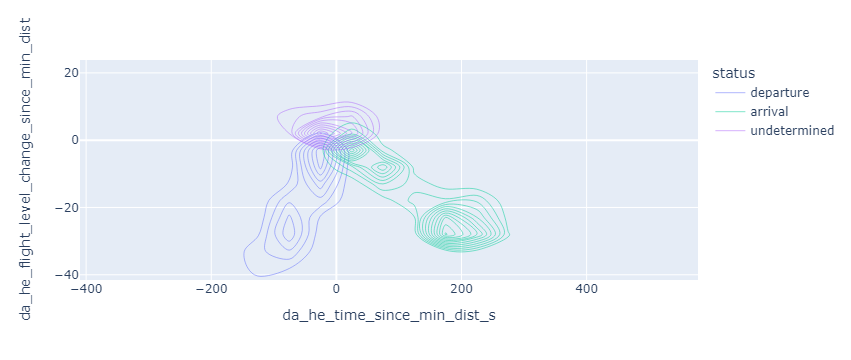

In [ ]:
import plotly.express as px

px.density_contour(heuristics_pdf, x='da_he_time_since_min_dist_s', y = 'da_he_flight_level_change_since_min_dist', color = 'status')

In [111]:
# Calculating heuristics (hr_) for runways (rwy), low numbered (le) and high numbered (he) approach cones

## Number of intersections heuristics

heuristics_pdf['hr_rwy_detection'] = heuristics_pdf['hex_rwy_intersected_subsections'] >= 1

heuristics_pdf['hr_he_high_detection'] = heuristics_pdf['hex_he_intersected_subsections'] / 10 # Max 10 subsections
heuristics_pdf['hr_le_high_detection'] = heuristics_pdf['hex_le_intersected_subsections'] / 10 # Max 10 subsections


# Close approach to runway heuristic

heuristics_pdf['hr_he_touch_rwy_1nm'] = heuristics_pdf['hex_he_min_gate_distance'] <= 1
heuristics_pdf['hr_he_touch_rwy_2nm'] = heuristics_pdf['hex_he_min_gate_distance'] <= 2

heuristics_pdf['hr_le_touch_rwy_1nm'] = heuristics_pdf['hex_le_min_gate_distance'] <= 1
heuristics_pdf['hr_le_touch_rwy_2nm'] = heuristics_pdf['hex_le_min_gate_distance'] <= 2

# Heading alligned 

heuristics_pdf['hr_he_heading_alligned'] = abs(heuristics_pdf['hex_he_heading_min'] - heuristics_pdf['he_heading_deg']) < 10 
heuristics_pdf['hr_le_heading_alligned'] = abs(heuristics_pdf['hex_le_heading_min'] - heuristics_pdf['le_heading_deg']) < 10

# Intersections 


# Calculate score

hr_rwy_detection_weight = 2
hr_section_detection_weight = 2
hr_touch_rwy_1nm_weight = 1.5
hr_touch_rwy_2nm_weight = 0.75
hr_heading_alligned_weight = 1

max_score = hr_rwy_detection_weight + hr_section_detection_weight + hr_touch_rwy_1nm_weight + hr_touch_rwy_2nm_weight + hr_heading_alligned_weight

heuristics_pdf['hr_he_score'] = (
                   heuristics_pdf['hr_rwy_detection'].fillna(0).apply(int)*hr_rwy_detection_weight + 
                   heuristics_pdf['hr_he_high_detection'].fillna(0).apply(float)*hr_section_detection_weight + 
                   heuristics_pdf['hr_he_touch_rwy_1nm'].fillna(0).apply(int)*hr_touch_rwy_1nm_weight + 
                   heuristics_pdf['hr_he_touch_rwy_2nm'].fillna(0).apply(int)*hr_touch_rwy_2nm_weight + 
                   heuristics_pdf['hr_he_heading_alligned'].fillna(0).apply(int)*hr_heading_alligned_weight
                  ) / max_score * 100

heuristics_pdf['hr_le_score'] = (
                   heuristics_pdf['hr_rwy_detection'].fillna(0).apply(int)*hr_rwy_detection_weight + 
                   heuristics_pdf['hr_le_high_detection'].fillna(0).apply(float)*hr_section_detection_weight + 
                   heuristics_pdf['hr_le_touch_rwy_1nm'].fillna(0).apply(int)*hr_touch_rwy_1nm_weight + 
                   heuristics_pdf['hr_le_touch_rwy_2nm'].fillna(0).apply(int)*hr_touch_rwy_2nm_weight + 
                   heuristics_pdf['hr_le_heading_alligned'].fillna(0).apply(int)*hr_heading_alligned_weight
                  ) / max_score * 100

In [112]:
heuristics_pdf.to_excel('test.xlsx')

In [110]:
hr_rwy_detection_weight/max_score

0.32

In [19]:
heuristics_pdf.hex_le_intersected_subsections.value_counts(dropna=False).sum()

19922

array([[<AxesSubplot: title={'center': 'airport_ident'}>]], dtype=object)

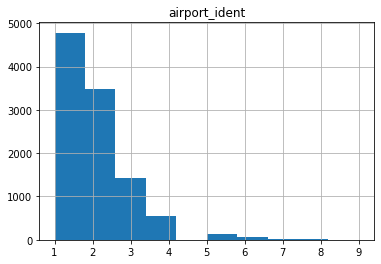

In [23]:
heuristics_pdf.groupby('track_id')['airport_ident'].count().reset_index().hist()

In [ ]:
heuristics_pdf.groupby('track_id')['airport_ident'].count().reset_index().sort_values

In [14]:
heuristics_pdf

AttributeError: 'DataFrame' object has no attribute 'gate_type'

In [21]:
cols_to_group = [
    "track_id", "icao24", "flight_id", 
    "airport_ident", "le_ident", "le_heading_deg", 
    "he_ident", "he_heading_deg", "min_gate_distance", 
    "max_gate_distance", , "intersected_subsections"]

min_dist_pdf['flight_id'] = min_dist_pdf.flight_id.fillna('')
min_dist_pdf = min_dist_pdf.groupby(cols_to_group).agg({
    'event_time': 'min',  # Taking the minimum of event_time
    'flight_level': 'min',  # Taking the minimum of flight_level
    'heading': 'median'  # Taking the median of heading
}).reset_index()

min_dist_pdf = min_dist_pdf.rename({
    'event_time':'time_entry_min_gate_distance',
    'flight_level': 'flight_lvl_min_gate_distance',
    'heading' : 'heading_min_gate_distance'
},axis=1)

max_dist_pdf['flight_id'] = max_dist_pdf.flight_id.fillna('')
max_dist_pdf = max_dist_pdf.groupby(cols_to_group).agg({
    'event_time': 'min',  # Taking the minimum of event_time
    'flight_level': 'min',  # Taking the minimum of flight_level
    'heading': 'median'  # Taking the median of heading
}).reset_index()

max_dist_pdf = max_dist_pdf.rename({
    'event_time':'time_entry_max_gate_distance', 
    'flight_level': 'flight_lvl_max_gate_distance',
    'heading' : 'heading_max_gate_distance'},axis=1)

KeyError: "Column(s) ['event_time', 'flight_level', 'heading'] do not exist"

In [18]:
dist_pdf = min_dist_pdf.merge(max_dist_pdf, on = cols_to_group, how = 'outer')

In [15]:
dist_pdf

NameError: name 'dist_pdf' is not defined

In [20]:
max_dist_approach_pdf

NameError: name 'max_dist_approach_pdf' is not defined

In [ ]:
df.groupby(['track_id', 'airport_ident'])

In [ ]:
pd = sv_on_rwy_cp.toPandas()

In [ ]:
pd

In [ ]:
pd.groupby(["track_id",  "airport_ident", "le_ident", "he_ident"]).

In [1]:
pd

NameError: name 'pd' is not defined

In [16]:
pd.columns

Index(['track_id', 'icao24', 'flight_id', 'event_time', 'lat', 'lon',
       'flight_level', 'heading', 'vert_rate', 'on_ground', 'h3_res_6',
       'h3_res_11', 'apt_hex_id', 'apt_ident', 'airport_ident', 'le_ident',
       'le_heading_deg', 'he_ident', 'he_heading_deg', 'hex_id', 'gate_id',
       'gate_id_nr', 'gate_type', 'gate_distance_from_rwy_nm',
       'min_gate_distance', 'max_gate_distance'],
      dtype='object')

In [14]:
# Merge the min and max values into the original DataFrame
sv_on_rwy_cp = sv_on_rwy_cp.join(min_values.select("track_id", "apt_ident", "le_ident", "he_ident", "min_gate_distance"), ["track_id", "apt_ident", "le_ident", "he_ident"], "left")
sv_on_rwy_cp = sv_on_rwy_cp.join(max_values.select("track_id", "apt_ident", "le_ident", "he_ident", "max_gate_distance"), ["track_id", "apt_ident", "le_ident", "he_ident"], "left")


In [13]:

# Filter rows where 'gate_distance_from_rwy_nm' matches the min or max values
result_min = sv_on_rwy_cp.filter(sv_on_rwy_cp['gate_distance_from_rwy_nm'] == sv_on_rwy_cp['min_gate_distance'])
result_max = sv_on_rwy_cp.filter(sv_on_rwy_cp['gate_distance_from_rwy_nm'] == sv_on_rwy_cp['max_gate_distance'])

# Selecting and renaming columns
cols_of_interest = ["track_id", "apt_ident", "le_ident", "he_ident", "min_gate_distance", "max_gate_distance"]
result_min = result_min.select(*cols_of_interest)
result_max = result_max.select(*cols_of_interest)

# Merge the min and max DataFrames
det = result_min.join(result_max, ["track_id", "apt_ident", "le_ident", "he_ident"], "outer")


In [ ]:
det_pd = det.toPandas()

In [ ]:
det_pd

In [ ]:

# Adding and computing additional columns
det = det.withColumn("time_since_minimum_distance_s", (F.col("min_gate_distance") - F.col("max_gate_distance")) * 1000)  # Assuming time columns are in seconds

# Adding status based on time since minimum distance
det = det.withColumn("status", F.when(F.col("time_since_minimum_distance_s") > 0, "arrival").otherwise("departure"))

# Final selection of columns
det_final = det.select("track_id", "apt_ident", "le_ident", "he_ident", "status")

# Additional aggregations as per the original requirement
gb_cols = ["track_id", "apt_ident", "le_ident", "he_ident", "gate_type"]
result_agg = sv_on_rwy.groupBy(gb_cols).agg(
    F.min("min").alias("entry_time_approach_area"),
    F.max("max").alias("exit_time_approach_area"),
    F.count("gate_distance_from_rwy_nm").alias("intersected_subsections"),
    F.min("gate_distance_from_rwy_nm").alias("minimal_distance_runway"),
    F.max("gate_distance_from_rwy_nm").alias("maximal_distance_runway")
).reset_index()


AnalysisException: Reference 'min_gate_distance' is ambiguous, could be: min_gate_distance, min_gate_distance.

In [ ]:
rs = result_agg.toPandas()

In [16]:
test[['track_id', 'event_time', 'time_diff']]

track_id          event_time  time_diff
0               01010a_0 2023-01-06 01:55:50        NaN
1      0101b6_MSR714  _0 2023-01-07 02:44:55        NaN
2      0101b6_MSR714  _0 2023-01-07 02:45:00        5.0
3      0101b6_MSR714  _0 2023-01-07 02:45:05        5.0
4      0101b6_MSR714  _0 2023-01-07 02:45:05        0.0
...                  ...                 ...        ...
73463  acbeab_FDX6257 _0 2023-01-04 03:42:35        0.0
73464  acbeab_FDX6257 _0 2023-01-04 03:42:40        5.0
73465  acbeab_FDX6257 _0 2023-01-04 03:42:40        0.0
73466  acbeab_FDX6257 _0 2023-01-04 03:42:45        5.0
73467  acbeab_FDX6257 _0 2023-01-04 03:42:45        0.0

[73468 rows x 3 columns]

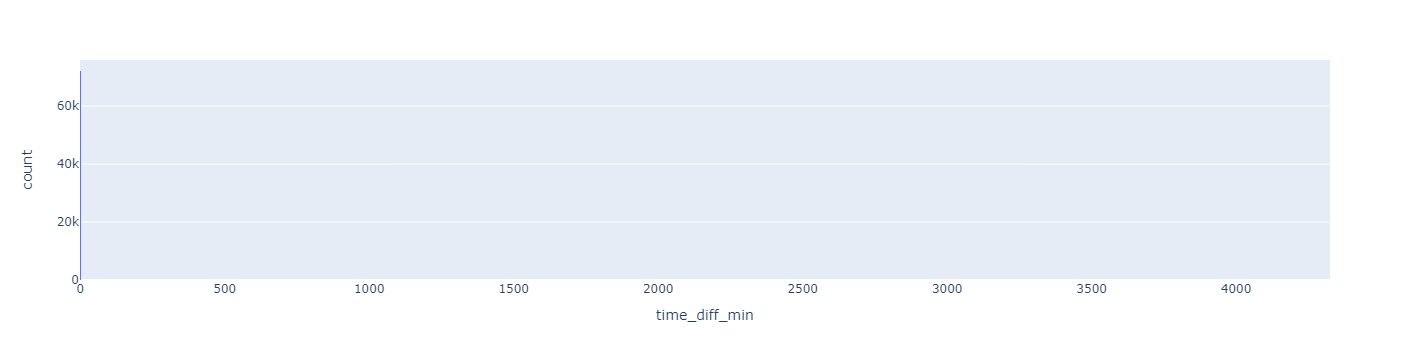

In [20]:
import plotly.express as px

test['time_diff_min'] = test.time_diff/60
px.histogram(test,x='time_diff_min', nbins = 3000)

In [41]:
tmp = test[np.logical_and(test.icao24.str.strip() == '4ca4f4', test.flight_id.str.strip() == 'RYR1BU')]

In [60]:
tmp = test[test.track_id== 'ae01cd_JAKE11  _0']

In [61]:
tmp

track_id  icao24 flight_id          event_time        lat  \
67269  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:40:45  52.369871   
67270  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:40:50  52.365509   
67271  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:40:55  52.360933   
67272  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:41:00  52.356674   
67273  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:41:05  52.352740   
...                  ...     ...       ...                 ...        ...   
67349  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:50:05  52.359676   
67350  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:50:10  52.360607   
67351  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:50:15  52.361389   
67352  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:50:20  52.361389   
67353  ae01cd_JAKE11  _0  ae01cd  JAKE11   2023-01-04 17:50:25  52.362190   

            lon  flight_level     heading  vert_rate  on_ground  ...  \
67269  1.039307            27  197.014683   -3.57632      False  ...   
67270  1.037140            27  196.642091   -4.87680      False  ...   
67271  1.034912            26  196.642091   -3.90144      False  ...   
67272  1.032867            26  196.440380   -0.97536      False  ...   
67273  1.030988            26  195.736135    0.00000      False  ...   
...         ...           ...         ...        ...        ...  ...   
67349  0.501918             0  283.172553   -2.60096      False  ...   
67350  0.495719             0  283.528315    0.65024      False  ...   
67351  0.490494             0  283.313632    0.65024      False  ...   
67352  0.490494             0  283.313632    0.65024      False  ...   
67353  0.484732             0  283.270644    0.97536      False  ...   

      airport_ident le_ident le_heading_deg he_ident he_heading_deg  \
67269          EGXH       09           81.0       27          261.0   
67270          EGXH       09           81.0       27          261.0   
67271          EGXH       09           81.0       27          261.0   
67272          EGXH       09           81.0       27          261.0   
67273          EGXH       09           81.0       27          261.0   
...             ...      ...            ...      ...            ...   
67349          EGUN       10          103.0       28          283.0   
67350          EGUN       10          103.0       28          283.0   
67351          EGUN       10          103.0       28          283.0   
67352          EGUN       10          103.0       28          283.0   
67353          EGUN       10          103.0       28          283.0   

                hex_id                               gate_id gate_id_nr  \
67269  8b194166b492fff  low_numbered_approach_hexagons_10_nm      10000   
67270  8b194164ca36fff  low_numbered_approach_hexagons_10_nm      10000   
67271  8b194164cadefff  low_numbered_approach_hexagons_10_nm      10000   
67272  8b194164c246fff  low_numbered_approach_hexagons_10_nm      10000   
67273  8b194164d59dfff  low_numbered_approach_hexagons_10_nm      10000   
...                ...                                   ...        ...   
67349  8b194ed1dd33fff                       runway_hexagons      20000   
67350  8b194ed1caccfff                       runway_hexagons      20000   
67351  8b194ed1c304fff                       runway_hexagons      20000   
67352  8b194ed1c304fff                       runway_hexagons      20000   
67353  8b194ed1c3b0fff                       runway_hexagons      20000   

                            gate_type gate_distance_from_rwy_nm  
67269  low_numbered_approach_hexagons                        10  
67270  low_numbered_approach_hexagons                        10  
67271  low_numbered_approach_hexagons                        10  
67272  low_numbered_approach_hexagons                        10  
67273  low_numbered_approach_hexagons                        10  
...                               ...                       ...  
67349     

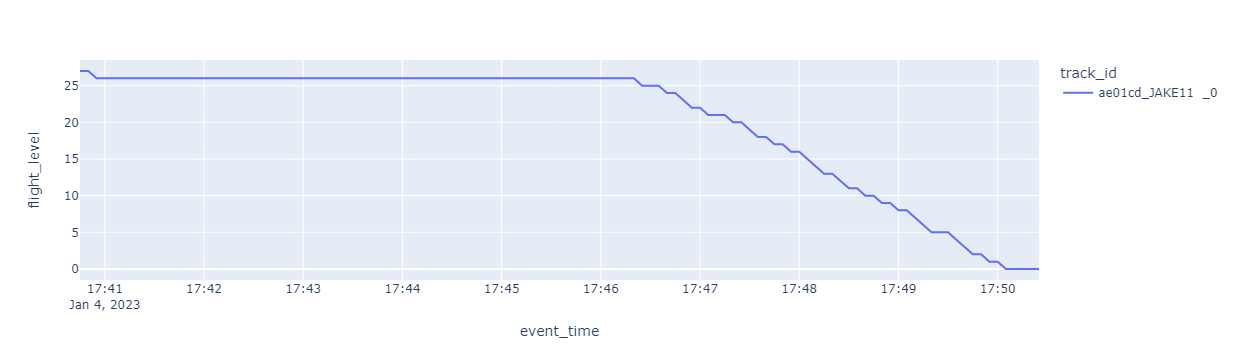

In [62]:
px.line(tmp, x='event_time', y = 'flight_level', color = 'track_id')

In [29]:
test[test.track_id.str.split('_').apply(lambda l:l[-1])=='1']

track_id  icao24 flight_id          event_time        lat  \
635    3415ce_IBE30LT _1  3415ce  IBE30LT  2023-01-04 17:53:00  41.365620   
636    3415ce_IBE30LT _1  3415ce  IBE30LT  2023-01-04 17:53:00  41.365620   
637    3415ce_IBE30LT _1  3415ce  IBE30LT  2023-01-04 17:53:05  41.363944   
638    3415ce_IBE30LT _1  3415ce  IBE30LT  2023-01-04 17:53:05  41.363944   
639    3415ce_IBE30LT _1  3415ce  IBE30LT  2023-01-04 17:53:10  41.362175   
...                  ...     ...       ...                 ...        ...   
63989  4ca4f4_RYR1BU  _1  4ca4f4  RYR1BU   2023-01-04 17:58:50  51.159140   
63990  4ca4f4_RYR1BU  _1  4ca4f4  RYR1BU   2023-01-04 17:58:55  51.159140   
63991  4ca4f4_RYR1BU  _1  4ca4f4  RYR1BU   2023-01-04 17:58:55  51.159140   
63992  4ca4f4_RYR1BU  _1  4ca4f4  RYR1BU   2023-01-04 17:59:00  51.159140   
63993  4ca4f4_RYR1BU  _1  4ca4f4  RYR1BU   2023-01-04 17:59:00  51.159140   

            lon  flight_level     heading  vert_rate  on_ground  ...  \
635    2.279289            18  246.068975   -0.32512      False  ...   
636    2.279289            18  246.068975   -0.32512      False  ...   
637    2.274357            18  245.942651    0.00000      False  ...   
638    2.274357            18  245.942651    0.00000      False  ...   
639    2.268989            18  245.942651    0.00000      False  ...   
...         ...           ...         ...        ...        ...  ...   
63989 -0.110168             9  258.088785   -3.57632      False  ...   
63990 -0.110168             9  258.088785   -3.57632      False  ...   
63991 -0.110168             9  258.088785   -3.57632      False  ...   
63992 -0.110168             9  258.088785   -3.57632      False  ...   
63993 -0.110168             9  258.088785   -3.57632      False  ...   

      airport_ident le_ident le_heading_deg he_ident he_heading_deg  \
635            LEBL      06L           66.0      24R          246.0   
636            LEBL      06R           66.0      24L          246.0   
637            LEBL      06L           66.0      24R          246.0   
638            LEBL      06R           66.0      24L          246.0   
639            LEBL      06L           66.0      24R          246.0   
...             ...      ...            ...      ...            ...   
63989          EGKK      08R           78.0      26L          258.0   
63990          EGKK      08L           78.0      26R          258.0   
63991          EGKK      08R           78.0      26L          258.0   
63992          EGKK      08L           78.0      26R          258.0   
63993          EGKK      08R           78.0      26L          258.0   

                hex_id                               gate_id gate_id_nr  \
635    8b394465238efff  low_numbered_approach_hexagons_10_nm      10000   
636    8b394465238efff  low_numbered_approach_hexagons_10_nm      10000   
637    8b394465272dfff  low_numbered_approach_hexagons_10_nm      10000   
638    8b394465272dfff  low_numbered_approach_hexagons_10_nm      10000   
639    8b3944652445fff  low_numbered_approach_hexagons_10_nm      10000   
...                ...                                   ...        ...   
63989  8b194ace90b3fff   low_numbered_approach_hexagons_4_nm      14000   
63990  8b194ace90b3fff   low_numbered_approach_hexagons_4_nm      14000   
63991  8b194ace90b3fff   low_numbered_approach_hexagons_4_nm      14000   
63992  8b194ace90b3fff   low_numbered_approach_hexagons_4_nm      14000   
63993  8b194ace90b3fff   low_numbered_approach_hexagons_4_nm      14000   

                            gate_type gate_distance_from_rwy_nm  
635    low_numbered_approach_hexagons                        10  
636    low_numbered_approach_hexagons                        10  
637    low_numbered_approach_hexagons                        10  
638    low_numbered_approach_hexagons                        10  
639    low_numbered_approach_hexagons                        10  
...                               ...                       ...  
63989  low

In [14]:
test.gate_type.value_counts()

low_numbered_approach_hexagons     28091
high_numbered_approach_hexagons    14158
runway_hexagons                     3408
Name: gate_type, dtype: int64

In [ ]:
5/60

0.08333333333333333

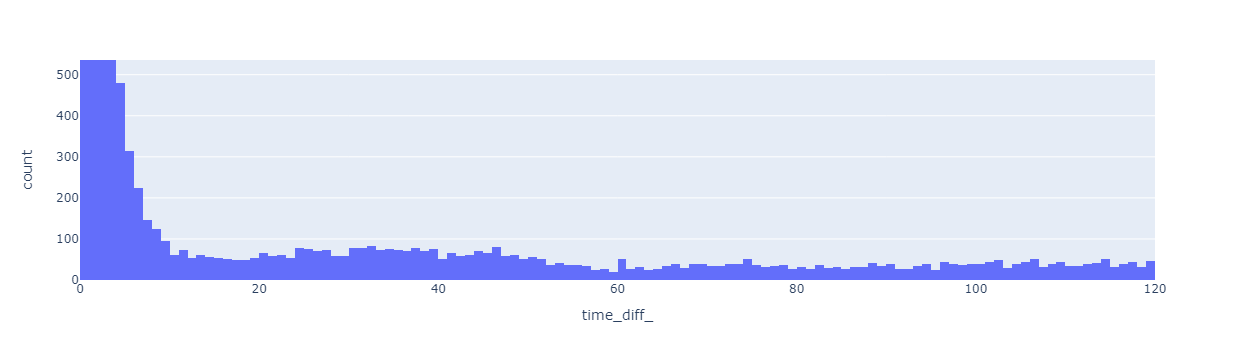

In [ ]:
import plotly.express as px
tmp['time_diff_'] = tmp['time_diff']/60

tmp_ = tmp[tmp['time_diff_'] > 5/60]
tmp_ = tmp_[tmp_['time_diff_'] < 120]
px.histogram(tmp_, x='time_diff_')

In [97]:
tmp.sort_values(['track_id','event_time'])

track_id  icao24 flight_id          event_time        lat  \
11001           0100dd  0100dd      None 2023-01-07 11:20:15  36.787021   
18359           0100dd  0100dd      None 2023-01-07 11:20:20  36.786602   
18360           0100dd  0100dd      None 2023-01-07 11:20:25  36.786602   
18361           0100dd  0100dd      None 2023-01-07 11:20:30  36.786602   
18362           0100dd  0100dd      None 2023-01-07 11:20:35  36.786602   
...                ...     ...       ...                 ...        ...   
37553  e48ced_PPCFJ     e48ced  PPCFJ    2023-01-07 11:02:05  41.793137   
22877  e48ced_PPCFJ     e48ced  PPCFJ    2023-01-07 11:02:10  41.788035   
26619  e48ced_PPCFJ     e48ced  PPCFJ    2023-01-07 11:02:15  41.786034   
4623   e48ced_PPCFJ     e48ced  PPCFJ    2023-01-07 11:02:20  41.783985   
1206   e48ced_PPCFJ     e48ced  PPCFJ    2023-01-07 11:02:25  41.777608   

             lon  flight_level     heading  vert_rate  on_ground  ...  \
11001   3.385834            19  263.589160   -3.90144      False  ...   
18359   3.384140            19  263.589160   -3.90144      False  ...   
18360   3.384140            19  263.589160   -3.90144      False  ...   
18361   3.384140            19  263.589160   -3.90144      False  ...   
18362   3.384140            19  263.589160   -3.90144      False  ...   
...          ...           ...         ...        ...        ...  ...   
37553  12.598884             5  156.236178   18.53184      False  ...   
22877  12.601957            10  155.170653   18.85696      False  ...   
26619  12.603171            12  154.425555   13.65504      False  ...   
4623   12.604512            14  160.676816   13.32992      False  ...   
1206   12.606875            18  175.548826   16.58112      False  ...   

            apt_hex_id                 apt_ident airport_ident le_ident  \
11001  86395a797ffffff                    [DAAG]          DAAG       05   
18359  86395a797ffffff                    [DAAG]          DAAG       05   
18360  86395a797ffffff                    [DAAG]          DAAG       05   
18361  86395a797ffffff                    [DAAG]          DAAG       05   
18362  86395a797ffffff                    [DAAG]          DAAG       05   
...                ...                       ...           ...      ...   
37553  861e8042fffffff  [LIRA, LIRE, LIRG, LIRU]          LIRA       15   
22877  861e8042fffffff  [LIRA, LIRE, LIRG, LIRU]          LIRA       15   
26619  861e8042fffffff  [LIRA, LIRE, LIRG, LIRU]          LIRA       15   
4623   861e8042fffffff  [LIRA, LIRE, LIRG, LIRU]          LIRA       15   
1206   861e8042fffffff  [LIRA, LIRE, LIRG, LIRU]          LIRA       15   

      le_heading_deg he_ident  he_heading_deg           hex_id  \
11001           53.0       23           233.0  8b395a795309fff   
18359           53.0       23           233.0  8b395a795303fff   
18360           53.0       23           233.0  8b395a795303fff   
18361           53.0       23           233.0  8b395a795303fff   
18362           53.0       23           233.0  8b395a795303fff   
...              ...      ...             ...              ...   
37553          152.0       33           332.0  8b1e8042e331fff   
22877          152.0       33           332.0  8b1e8042e2a9fff   
26619          152.0       33           332.0  8b1e8042e2d2fff   
4623           152.0       33           332.0  8b1e8042a90bfff   
1206           152.0       33           332.0  8b1e8042a12dfff   

                                   gate_id gate_id_nr  
11001  low_numbered_approach_hexagons_9_nm      19000  
18359  low_numbered_approach_hexagons_9_nm      19000  
18360  low_numbered_approach_hexagons_9_nm      19000  
18361  low_numbered_approach_hexagons_9_nm      19000  
18362  low_numbered_approach_hexagons_9_nm      19000  
...                                    ...        ...  
37553                      runway_hexagons      20000  
22877  low_numbered_approach_hexagons_1_nm      11000  
26619  low_numbered_approach_hexagons_

In [55]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Assuming arr_dep_apt is your Spark DataFrame and 'track_id_col' is defined

# Step 1: Initialize the 'segment_status' column with an empty string
arr_dep_apt = arr_dep_apt.withColumn('segment_status', F.lit(''))

# Step 2: Create a window specification partitioned by 'track_id_col' and 'ident'
track_id_col = 'track_id_tmp'
windowSpec = Window.partitionBy(track_id_col, 'apt_ident')

# Finding the min and max time for each group
min_time = F.min('event_time').over(windowSpec)
max_time = F.max('event_time').over(windowSpec)

# Step 3: Mark the 'start' and 'end' based on the min and max times
arr_dep_apt = arr_dep_apt.withColumn('segment_status', 
                                     F.when(F.col('event_time') == min_time, 'start')
                                     .when(F.col('event_time') == max_time, 'end')
                                     .otherwise(F.col('segment_status')))

# Step 4: Filter to only include 'start' or 'end'
filtered_df = arr_dep_apt.filter(F.col('segment_status').isin(['start', 'end']))


In [56]:
tmp = filtered_df.toPandas()

/opt/spark/python/lib/pyspark.zip/pyspark/sql/pandas/conversion.py:194: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [58]:
tmp.columns

Index(['event_time', 'icao24', 'lat', 'lon', 'velocity', 'heading',
       'vert_rate', 'callsign', 'on_ground', 'alert', 'spi', 'squawk',
       'baro_altitude', 'geo_altitude', 'last_pos_update', 'last_contact',
       'serials', 'h3_res_12', 'h3_res_11', 'h3_res_10', 'h3_res_9',
       'h3_res_8', 'h3_res_7', 'h3_res_6', 'h3_res_5', 'h3_res_4', 'h3_res_3',
       'h3_res_2', 'h3_res_1', 'h3_res_0', 'baroaltitude_ft',
       'baroaltitude_fl', 'low_alt', 'apt_hex_id', 'apt_ident', 'track_id_tmp',
       'segment_status'],
      dtype='object')

### Main runway merge

In [11]:
from pyspark.sql.functions import collect_list

In [12]:
rwy_sdf_dedup = rwy_sdf.groupBy("hex_id", "hex_res", "hex_lon", "hex_lat").agg(
    collect_list("airport_ident").alias("airport_ident_list"),
    collect_list("le_ident").alias("le_ident_list"),
    collect_list("le_heading_deg").alias("le_heading_deg_list"),
    collect_list("he_ident").alias("he_ident_list"),
    collect_list("he_heading_deg").alias("he_heading_deg_list"),
    collect_list("gate_id").alias("gate_id_list"),
    collect_list("gate_id_nr").alias("gate_id_nr_list")
)

In [24]:
df = sdf_fi.toPandas()

In [30]:
tmp = df[~df['gate_id_list'].isna()]

In [35]:
tmp.id.value_counts()

440614_EJU74QN     101
4cad3f_RYR56JP      96
40624f_SHT9Y        84
40600d_EZY36BN      65
45ac37_SAS688       49
48414c_TRA16E       47
392af8_AFR14DF      45
4b1a29_EZS18TE      37
393323_AFR36TM      31
4010ee_EZY87RE      29
4d012c_CLX9874      29
71005b_SVA9062      17
Name: id, dtype: int64

In [38]:
tmp[tmp.id.str.contains('440614_EJU74QN')].sort_values('event_time')

event_time  icao24        lat       lon   velocity     heading  \
1513  1672951360  440614  44.942089 -0.552934  95.309689  225.437364   
2354  1672951365  440614  44.938225 -0.558494  94.582177  225.440728   
3749  1672951370  440614  44.934967 -0.563183  93.863124  225.888235   
4456  1672951375  440614  44.931754 -0.567806  92.766964  225.674037   
4457  1672951380  440614  44.928772 -0.572074  91.311999  225.684778   
...          ...     ...        ...       ...        ...         ...   
1146  1672951840  440614  44.842560 -0.695421  68.025372  225.306392   
1147  1672951845  440614  44.842560 -0.695421  68.025372  225.306392   
1148  1672951850  440614  44.842560 -0.695421  68.025372  225.306392   
1149  1672951855  440614  44.842560 -0.695421  68.025372  225.306392   
1150  1672951860  440614  44.842560 -0.695421  68.025372  225.306392   

      vert_rate  callsign  on_ground  alert  ...   hex_lon    hex_lat  \
1513   -2.60096  EJU74QN       False  False  ... -0.552861  44.941940   
2354   -5.20192  EJU74QN       False  False  ... -0.558716  44.938240   
3749   -5.20192  EJU74QN       False  False  ... -0.563169  44.935062   
4456   -5.20192  EJU74QN       False  False  ... -0.567622  44.931885   
4457   -5.52704  EJU74QN       False  False  ... -0.572074  44.928707   
...         ...       ...        ...    ...  ...       ...        ...   
1146   -3.90144  EJU74QN       False  False  ... -0.695178  44.842491   
1147   -3.90144  EJU74QN       False  False  ... -0.695178  44.842491   
1148   -3.90144  EJU74QN       False  False  ... -0.695178  44.842491   
1149   -3.90144  EJU74QN       False  False  ... -0.695178  44.842491   
1150   -3.90144  EJU74QN       False  False  ... -0.695178  44.842491   

      airport_ident_list  le_ident_list  le_heading_deg_list  he_ident_list  \
1513              [LFBD]           [05]               [46.0]           [23]   
2354              [LFBD]           [05]               [46.0]           [23]   
3749              [LFBD]           [05]               [46.0]           [23]   
4456              [LFBD]           [05]               [46.0]           [23]   
4457              [LFBD]           [05]               [46.0]           [23]   
...                  ...            ...                  ...            ...   
1146              [LFBD]           [05]               [46.0]           [23]   
1147              [LFBD]           [05]               [46.0]           [23]   
1148              [LFBD]           [05]               [46.0]           [23]   
1149              [LFBD]           [05]               [46.0]           [23]   
1150              [LFBD]           [05]               [46.0]           [23]   

     he_heading_deg_list                            gate_id_list  \
1513             [226.0]  [low_numbered_approach_hexagons_10_nm]   
2354             [226.0]  [low_numbered_approach_hexagons_10_nm]   
3749             [226.0]  [low_numbered_approach_hexagons_10_nm]   
4456             [226.0]   [low_numbered_approach_hexagons_9_nm]   
4457             [226.0]   [low_numbered_approach_hexagons_9_nm]   
...                  ...                                     ...   
1146             [226.0]   [low_numbered_approach_hexagons_2_nm]   
1147             [226.0]   [low_numbered_approach_hexagons_2_nm]   
1148             [226.0]   [low_numbered_approach_hexagons_2_nm]   
1149             [226.0]   [low_numbered_approach_hexagons_2_nm]   
1150             [226.0]   [low_numbered_approach_hexagons_2_nm]   

     gate_id_nr_list               id  
1513         [10000]  440614_EJU74QN   
2354         [10000]  440614_EJU74QN   
3749         [10000]  440614_EJU74QN   
4456         [19000]  440614_EJU74QN   
4457         [19000]  440614_EJU74QN   
...              ...              ...  
1146         [12000]  440614_EJU74QN   
1147         [12000]  440614_EJU74QN   
1148         [12000]  440614_EJU74QN   
1149         [12000]  440614_EJU74QN   
1150         [12000]  440614_EJU74QN   

[101 rows x 47 co

In [28]:
df['id'].value_counts()

KeyError: 'id'

In [15]:
df[df.baro_altitude.isna()]

Empty DataFrame
Columns: [event_time, icao24, lat, lon, velocity, heading, vert_rate, callsign, on_ground, alert, spi, squawk, baro_altitude, geo_altitude, last_pos_update, last_contact, serials, h3_res_12, h3_res_11, h3_res_10, h3_res_9, h3_res_8, h3_res_7, h3_res_6, h3_res_5, h3_res_4, h3_res_3, h3_res_2, h3_res_1, h3_res_0, baroaltitude_ft, baroaltitude_fl, low_alt, apt_hex_id, apt_ident, hex_id, hex_res, hex_lon, hex_lat, airport_ident_list, le_ident_list, le_heading_deg_list, he_ident_list, he_heading_deg_list, gate_id_list, gate_id_nr_list]
Index: []

[0 rows x 46 columns]